<h1>Problem Statement<h1>

Overview

This is a binary classification problem where you need to predict whether an ad buy will lead to a netgain.

**Uploading the data into Google Colab**

In [102]:
# from google.colab import files
# files.upload()

# !unzip -q AdGain.zip

**DATA DESCRIPTION**

Column Name | Description
----------- |-----------------
UserID 	|Unique id for each row
ratings |	Metric out of 1 which represents how much of the targeted demographic watched the advertisement
airlocation |	Country of origin
airtime |	Time when the advertisement was aired
average_runtime(minutes_per_week) |	Minutes per week the advertisement was aired
targeted_sex |	Sex that was mainly targeted for the advertisement
genre |	The type of advertisement
industry |	The industry to which the product belonged
relationship_status |	The relationship status of the most responsive customers to the advertisement
expensive |	A general measure of how expensive the product or service is that the ad is discussing
money_back_guarantee |	Whether or not the product offers a refund in the case of customer dissatisfaction
netgain |	Target, Whether the ad will incur a gain or loss when sold





*   We are having 10 features to predict the netgain
* **UserID** is the unique identifier for each observation
*   **netgain** is the target variable/ y column. It has binary values







<h1>Hypothesis Generation<h1>



*   Is higher ratings means net gains?
*   Is specific location of helps to gain in net?
*   Is at specific time ad is shown (air time) more likely gain net?
*   Is greater the runtime more likely to gain in net?
*   Is specific genre/industry likely to gain nets?
*   Is relationship status affects on net gains?
*   Is Expensive the product higher the gains or vice versa?
*   Is refund improve the gains?




In [103]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Imporing the mertics and models
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

%matplotlib inline
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter('ignore')

<h1>EDA<h1>

Before going to any kind of modelling, we will always want to have a look at the kind of data that we have.  

We have been provided three files. A description for what each of these files contain is given below:


1.     **SampleSubmission.csv**: This gives us a required format for submitting our solutions .
2.     **Train.csv**: We will use this file for training our model. It contains variables or features that we will input to our model, and the *target variable* that we want to predict.
3.     **Test.csv**: This will contain all variables in the training dataset except the *target variable*. We will use our trained model to predict the target for this dataset. 


In [104]:
#loading the files into dataframes
ss = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [105]:
#looking the first 5 obs. of sample submission data
ss.head()

,netgain
0,1
1,1
2,1
3,1
4,1


Lets go and explore our training and test datasets. We will do the following steps:

1. Brief Look at the Dataset
2. See the dataset shape.
3. Target Distribution.
4. See the variables datatypes.
5. See the number of missing/null values.
6. See the number of unique values in each variable. 


In [106]:
#looking first 5 obs. train dataset
train.head()

,UserID,realtionship_status,industry,genre,targeted_sex,average_runtime(minutes_per_week),airtime,airlocation,ratings,expensive,money_back_guarantee,netgain
0,UI_9185,Married-civ-spouse,Pharma,Comedy,Male,40,Daytime,United-States,0.027465,Medium,No,0
1,UI_449,Never-married,Political,Comedy,Male,35,Morning,International,0.027465,Low,No,0
2,UI_9014,Never-married,Auto,Comedy,Male,40,Morning,United-States,0.027465,Low,No,0
3,UI_14987,Married-civ-spouse,Pharma,Infomercial,Male,40,Primetime,United-States,0.027465,Low,Yes,0
4,UI_25532,Married-civ-spouse,Other,Comedy,Female,50,Primetime,United-States,0.027465,Low,Yes,1


In [107]:
#looking first 5 obs. of test dataset
test.head(3)

,UserID,realtionship_status,industry,genre,targeted_sex,average_runtime(minutes_per_week),airtime,airlocation,ratings,expensive,money_back_guarantee
0,UI_8772,Never-married,Entertainment,Infomercial,Female,40,Primetime,United-States,0.027465,High,Yes
1,UI_13139,Divorced,Auto,Comedy,Female,40,Primetime,United-States,0.027465,Low,No
2,UI_15381,Married-civ-spouse,Pharma,Infomercial,Male,40,Primetime,United-States,0.027465,High,No


In [108]:
#storing the tagert feature and userid in a variable
ID_COL, TARGET_COL = 'UserID','netgain'

In [109]:
#dataset shape
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables ')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables ')

features = [ c for c in train.columns if c not in [ID_COL,TARGET_COL]]
print(f'/Train data contains {len(features)} features')


Train contains 19536 samples and 12 variables 

Test contains 6512 samples and 11 variables 
/Train data contains 10 features


3.**target distribution**

In [110]:
train[TARGET_COL].value_counts(normalize=True)

0    0.761978
1    0.238022
Name: netgain, dtype: float64

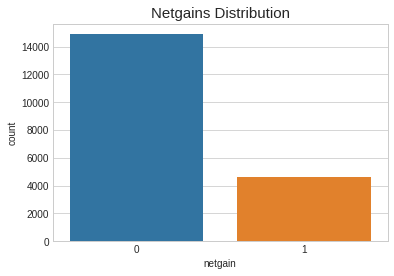

In [111]:
_ = sns.countplot(train[TARGET_COL])
_ = plt.title('Netgains Distribution',fontsize=15)
_  = plt.show()

on the plot we can't say that our data is very balanced. netgains ratio for gains is only 24%.


4. Variable Datatype

In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19536 entries, 0 to 19535
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   UserID                             19536 non-null  object 
 1   realtionship_status                19536 non-null  object 
 2   industry                           19536 non-null  object 
 3   genre                              19536 non-null  object 
 4   targeted_sex                       19536 non-null  object 
 5   average_runtime(minutes_per_week)  19536 non-null  int64  
 6   airtime                            19536 non-null  object 
 7   airlocation                        19536 non-null  object 
 8   ratings                            19536 non-null  float64
 9   expensive                          19536 non-null  object 
 10  money_back_guarantee               19536 non-null  object 
 11  netgain                            19536 non-null  int

5. Unique values in each variable

In [113]:
train.nunique()

UserID                               19536
realtionship_status                      7
industry                                 6
genre                                    5
targeted_sex                             2
average_runtime(minutes_per_week)       89
airtime                                  3
airlocation                             42
ratings                                120
expensive                                3
money_back_guarantee                     2
netgain                                  2
dtype: int64

In [114]:
null_values_per_variable = (train.isnull().sum()/train.shape[0]) * 100
null_values_per_variable.sort_values(ascending=False)

netgain                              0.0
money_back_guarantee                 0.0
expensive                            0.0
ratings                              0.0
airlocation                          0.0
airtime                              0.0
average_runtime(minutes_per_week)    0.0
targeted_sex                         0.0
genre                                0.0
industry                             0.0
realtionship_status                  0.0
UserID                               0.0
dtype: float64

<h1> Analyzing each variable and thier relation<h1>


In [115]:
train.columns

Index(['UserID', 'realtionship_status', 'industry', 'genre', 'targeted_sex',
       'average_runtime(minutes_per_week)', 'airtime', 'airlocation',
       'ratings', 'expensive', 'money_back_guarantee', 'netgain'],
      dtype='object')

Segregating categorical and numerical variable

In [116]:
cat_cols = train.select_dtypes(include='object').columns[1:]
print(cat_cols)

Index(['realtionship_status', 'industry', 'genre', 'targeted_sex', 'airtime',
       'airlocation', 'expensive', 'money_back_guarantee'],
      dtype='object')


In [117]:
num_cols = train.select_dtypes(include='number').columns
print(num_cols)

Index(['average_runtime(minutes_per_week)', 'ratings', 'netgain'], dtype='object')


**Univariate Analysis**

Categorical Variables- Pie charts

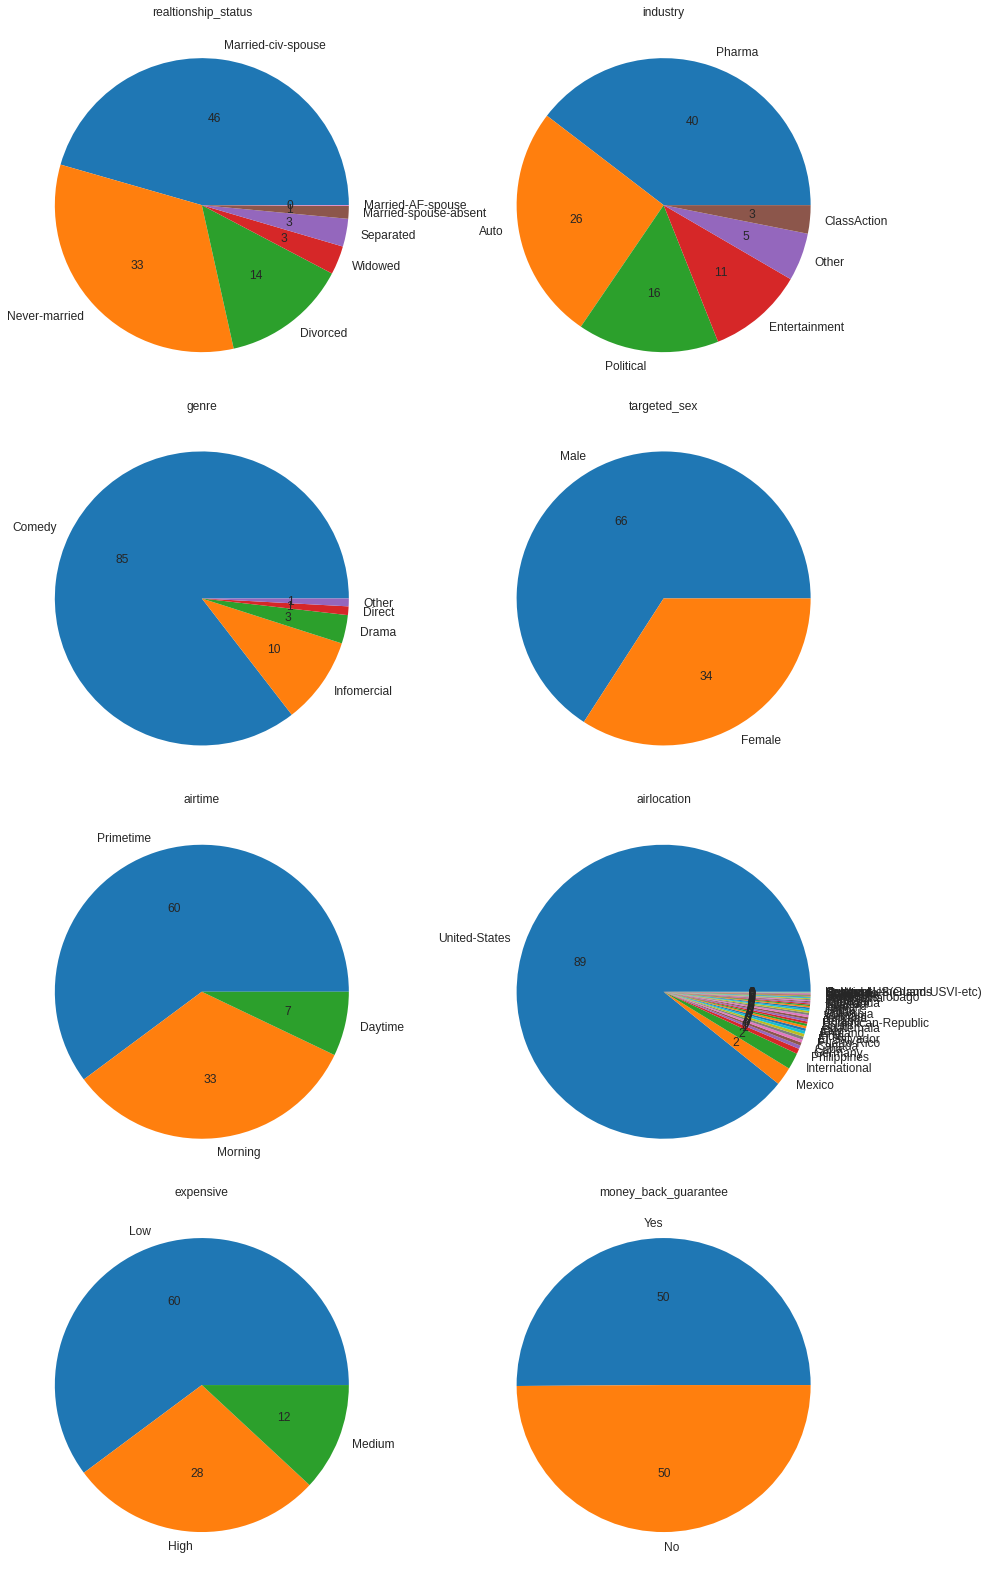

In [118]:
fig, axes = plt.subplots(4,2,figsize=(14,22))
axes = [ax for axes_row in axes for ax in axes_row]

for i,c in enumerate(train[cat_cols]):
  _= train[c].value_counts().plot(kind='pie',ax = axes[i],title = c, autopct = '%.0f',fontsize=12)
  _=axes[i].set_ylabel('')
_= plt.tight_layout()

Univariate analysis - Countsplot

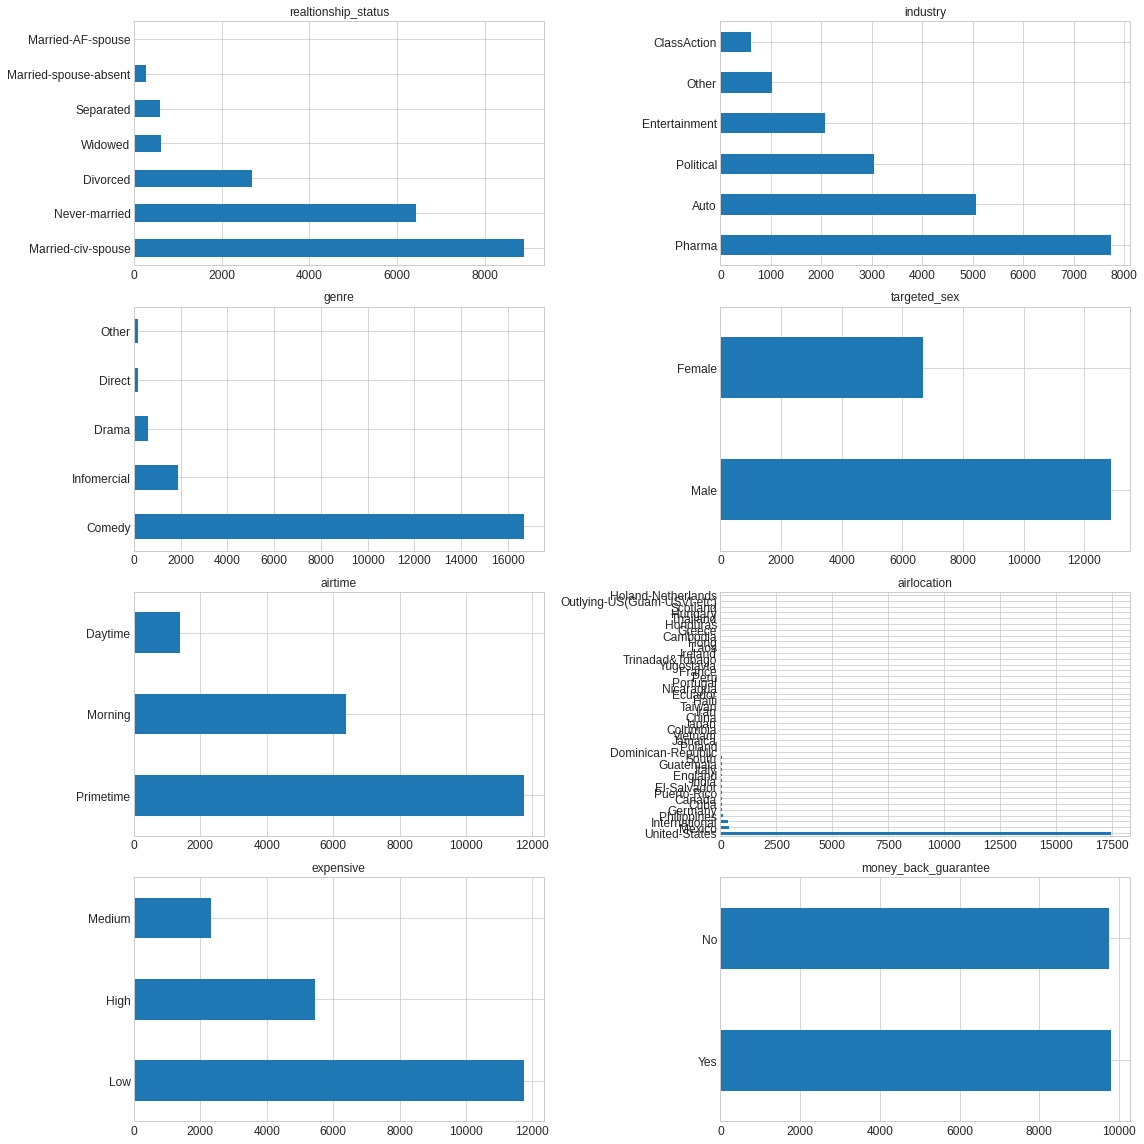

In [119]:
fig, axes = plt.subplots(4,2,figsize=(16,16))
axes = [ax for axes_row in axes for ax in axes_row]

for i,c in enumerate(train[cat_cols]):
  _= train[c].value_counts().plot(kind='barh',ax = axes[i],title = c,fontsize=12)
  _=axes[i].set_ylabel('')
_= plt.tight_layout()

**Bivariate analysis with target** 

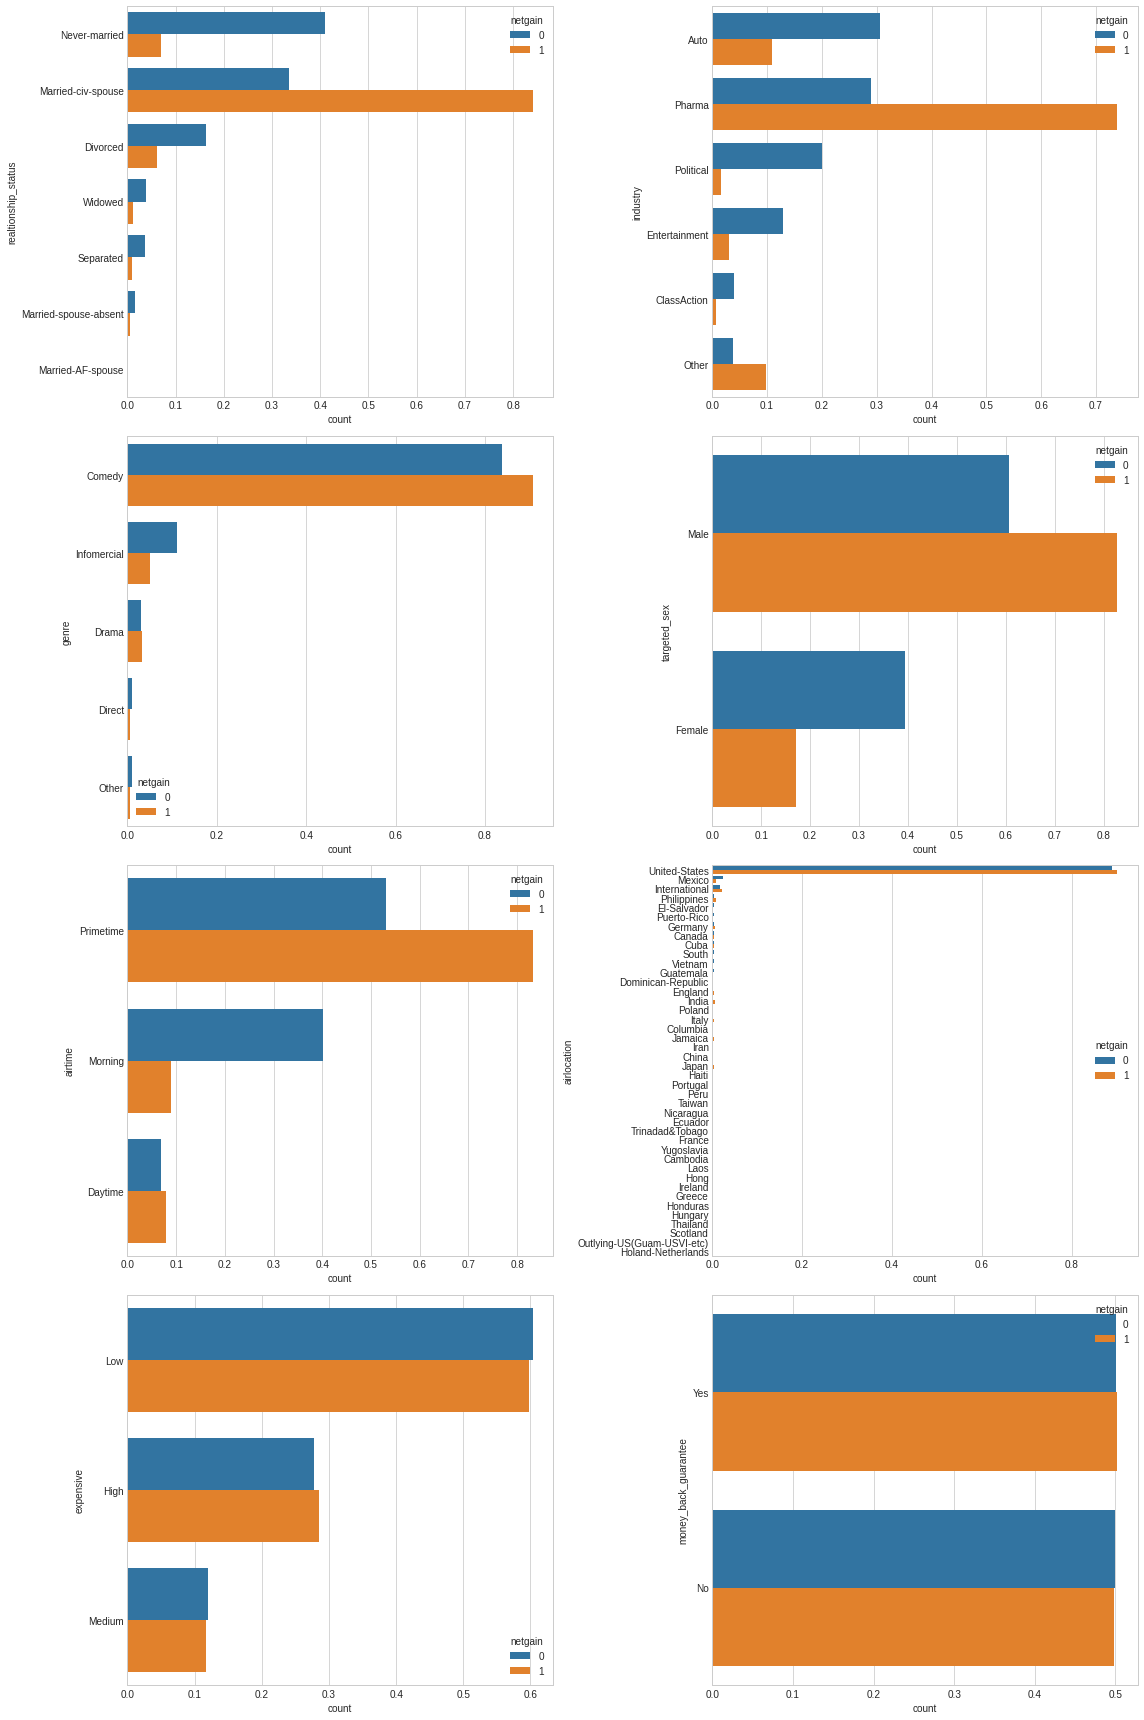

In [120]:
fig, axes = plt.subplots(4,2,figsize=(16,24))
axes = [ax for axes_row in axes for ax in axes_row]

for i,c in enumerate(train[cat_cols]):
  fltr = train[TARGET_COL] == 0

  vc_a = train[fltr][c].value_counts(normalize=True).reset_index().rename({'index':c, c:'count'},axis=1)

  vc_b = train[-fltr][c].value_counts(normalize=True).reset_index().rename({'index':c, c:'count'},axis=1)

  vc_a[TARGET_COL] = 0
  vc_b[TARGET_COL] = 1

  df = pd.concat([vc_a,vc_b]).reset_index(drop=True)

  _= sns.barplot(y = c, x='count', data=df, hue=TARGET_COL,ax=axes[i])

_= plt.tight_layout()


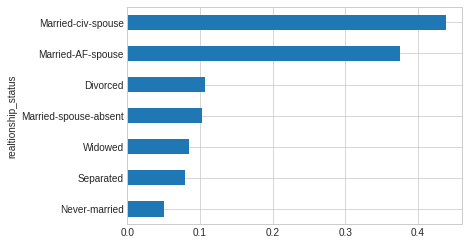

In [121]:
_ = train.groupby('realtionship_status')[TARGET_COL].mean().sort_values().plot(kind='barh')

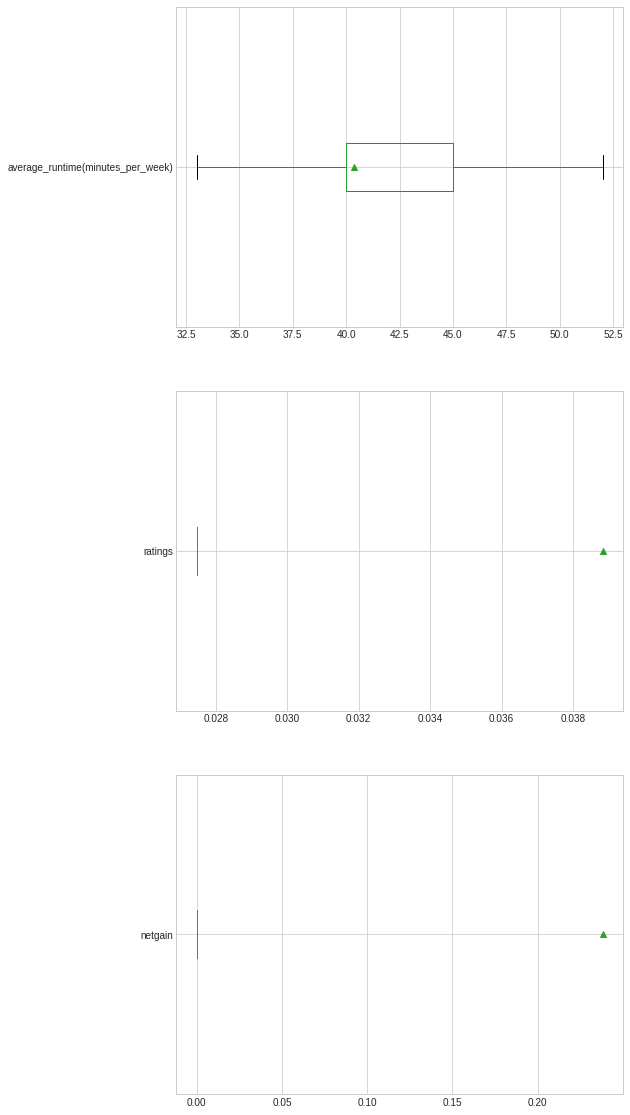

In [122]:
fig,axes = plt.subplots(3,1,figsize=(8,20))
for i , c in enumerate(train[num_cols]):
  _= (train[[c]]).boxplot(ax=axes[i],vert=False,showfliers=False,showmeans=True)

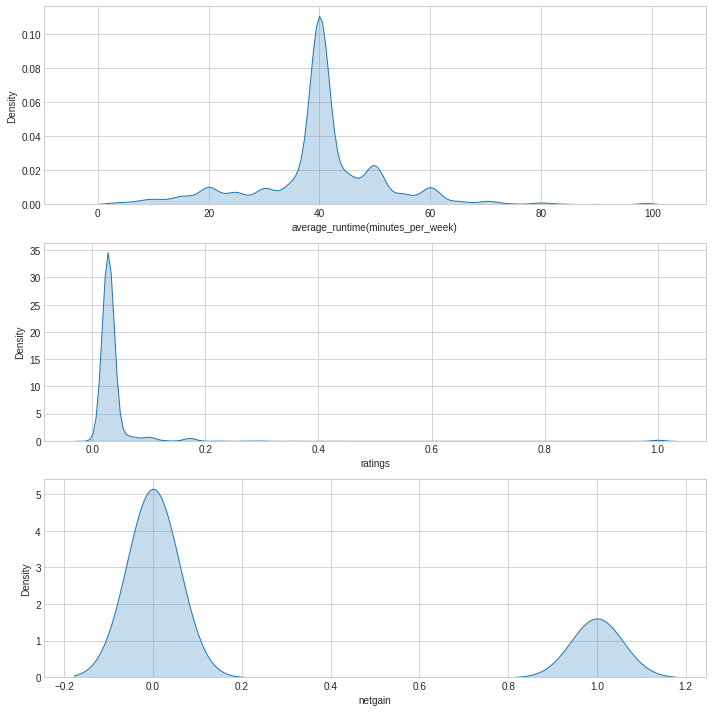

In [123]:
fig,axes = plt.subplots(3,1,figsize=(10,10))
for i , c in enumerate(train[num_cols]):
 
  _=sns.kdeplot(data=train,x=c,ax=axes[i],fill=True)
plt.tight_layout()

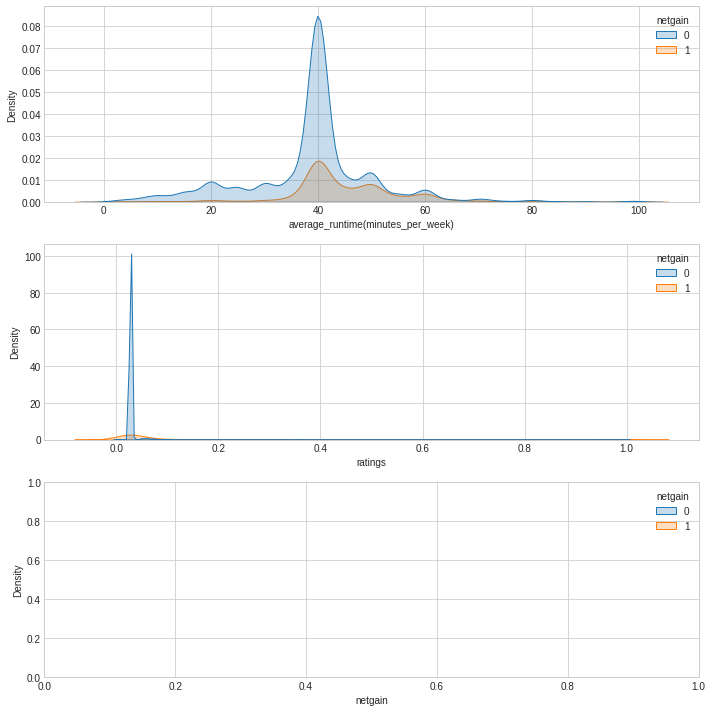

In [124]:
fig,axes = plt.subplots(3,1,figsize=(10,10))
for i , c in enumerate(train[num_cols]):
 
  _=sns.kdeplot(data=train,x=c,hue = TARGET_COL,ax=axes[i],fill=True)
plt.tight_layout()

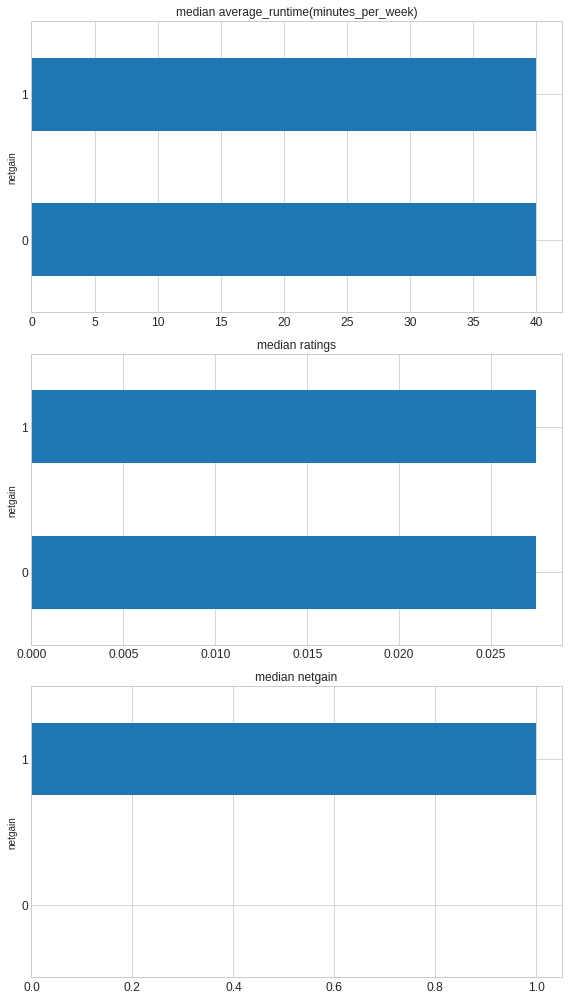

In [125]:
fig, axes = plt.subplots(3,1,figsize=(8,14))
# axes = [ax for axes_row in axes for ax in axes_row]

for i,c in enumerate(train[num_cols]):
  _= train.groupby(TARGET_COL)[c].median().plot(kind='barh',title = f'median {c}',fontsize=12,ax = axes[i])
_= plt.tight_layout()

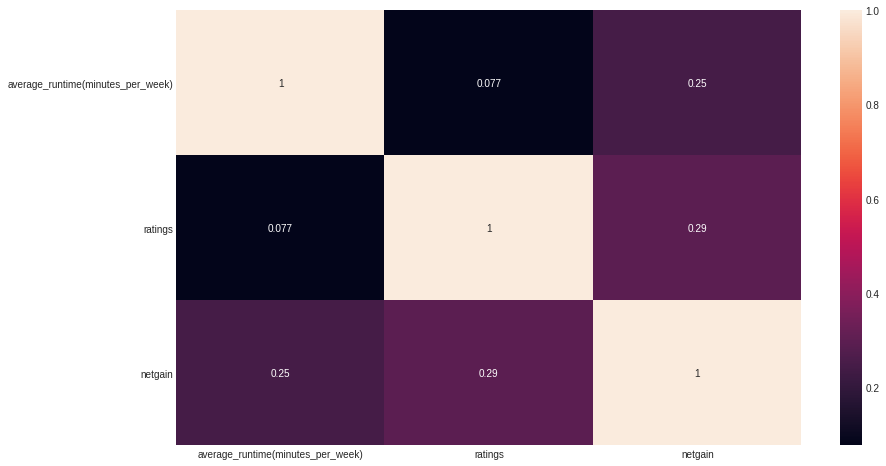

In [126]:
_ = plt.figure(figsize=(14,8))
_= sns.heatmap(train[num_cols].corr(method='spearman'),annot = True) 

In [127]:
# train.groupby(['realtionship_status','netgain','genre'])['netgain'].count()

In [128]:
#helper function
def download_pred(preds_test,file_name = 'hackthon_1_sub.csv'):
  ss[TARGET_COL] = preds_test

  ss.to_csv(file_name,index = False)

  from google.colab import files
  files.download(file_name)

<h1>Model A</h1>
predicting all instances as majority


In [129]:
target = train[TARGET_COL]
target.value_counts()

0    14886
1     4650
Name: netgain, dtype: int64

In [130]:
target

0        0
1        0
2        0
3        0
4        1
        ..
19531    0
19532    1
19533    0
19534    0
19535    0
Name: netgain, Length: 19536, dtype: int64

0 is majortiy class , Let's predicting everything as 0

In [131]:
from sklearn.metrics import accuracy_score,f1_score

In [132]:
preds_target = np.zeros(len(train))

accuracy = accuracy_score(target, preds_target)
f1 = f1_score(target,preds_target)
print(f'Accuracy score is {accuracy}')
print(f'f1 score is {f1}')

Accuracy score is 0.7619778869778869
f1 score is 0.0


<h1>Model B</h1>
Random predictions with equal probablitites

In [133]:
np.random.seed(2)
preds_target = np.random.choice([0,1],size = len(train))
accuracy = accuracy_score(target, preds_target)
f1 = f1_score(target,preds_target)
print(f'Accuracy score is {accuracy}')
print(f'f1 score is {f1}')

Accuracy score is 0.4980036855036855
f1 score is 0.3229547808077322


Concatenate the train and test dataset


In [134]:
df = pd.concat([train,test],axis=0).reset_index(drop=True)
df.shape

(26048, 12)

In [135]:
cat_col2 = train.select_dtypes(include='object').columns[1:]
cat_col2

Index(['realtionship_status', 'industry', 'genre', 'targeted_sex', 'airtime',
       'airlocation', 'expensive', 'money_back_guarantee'],
      dtype='object')

In [136]:
df = pd.get_dummies(df,columns=cat_col2)

In [137]:
df.head()

,UserID,average_runtime(minutes_per_week),ratings,netgain,realtionship_status_Divorced,realtionship_status_Married-AF-spouse,realtionship_status_Married-civ-spouse,realtionship_status_Married-spouse-absent,realtionship_status_Never-married,realtionship_status_Separated,realtionship_status_Widowed,industry_Auto,industry_ClassAction,industry_Entertainment,industry_Other,industry_Pharma,industry_Political,genre_Comedy,genre_Direct,genre_Drama,genre_Infomercial,genre_Other,targeted_sex_Female,targeted_sex_Male,airtime_Daytime,airtime_Morning,airtime_Primetime,airlocation_Cambodia,airlocation_Canada,airlocation_China,airlocation_Columbia,airlocation_Cuba,airlocation_Dominican-Republic,airlocation_Ecuador,airlocation_El-Salvador,airlocation_England,airlocation_France,airlocation_Germany,airlocation_Greece,airlocation_Guatemala,airlocation_Haiti,airlocation_Holand-Netherlands,airlocation_Honduras,airlocation_Hong,airlocation_Hungary,airlocation_India,airlocation_International,airlocation_Iran,airlocation_Ireland,airlocation_Italy,airlocation_Jamaica,airlocation_Japan,airlocation_Laos,airlocation_Mexico,airlocation_Nicaragua,airlocation_Outlying-US(Guam-USVI-etc),airlocation_Peru,airlocation_Philippines,airlocation_Poland,airlocation_Portugal,airlocation_Puerto-Rico,airlocation_Scotland,airlocation_South,airlocation_Taiwan,airlocation_Thailand,airlocation_Trinadad&Tobago,airlocation_United-States,airlocation_Vietnam,airlocation_Yugoslavia,expensive_High,expensive_Low,expensive_Medium,money_back_guarantee_No,money_back_guarantee_Yes
0,UI_9185,40,0.027465,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
1,UI_449,35,0.027465,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,UI_9014,40,0.027465,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
3,UI_14987,40,0.027465,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4,UI_25532,50,0.027465,1.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1


In [138]:
df.isnull().sum()
df.fillna(-999,inplace=True)
df.isnull().sum()

UserID                               0
average_runtime(minutes_per_week)    0
ratings                              0
netgain                              0
realtionship_status_Divorced         0
                                    ..
expensive_High                       0
expensive_Low                        0
expensive_Medium                     0
money_back_guarantee_No              0
money_back_guarantee_Yes             0
Length: 74, dtype: int64

In [139]:
train_proc,test_proc = df[:train.shape[0]],df[train.shape[0]:].reset_index(drop=True)
features = [c for c in train_proc.columns if c not in [ID_COL,TARGET_COL]]

In [140]:
len(features)

72

In [141]:
trn , val = train_test_split(train_proc, test_size = 0.2,random_state = 1,stratify = train_proc[TARGET_COL])

In [142]:
X_trn ,X_val =trn[features], val[features]

y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

X_test = test_proc[features]

In [143]:
X_test

,average_runtime(minutes_per_week),ratings,realtionship_status_Divorced,realtionship_status_Married-AF-spouse,realtionship_status_Married-civ-spouse,realtionship_status_Married-spouse-absent,realtionship_status_Never-married,realtionship_status_Separated,realtionship_status_Widowed,industry_Auto,industry_ClassAction,industry_Entertainment,industry_Other,industry_Pharma,industry_Political,genre_Comedy,genre_Direct,genre_Drama,genre_Infomercial,genre_Other,targeted_sex_Female,targeted_sex_Male,airtime_Daytime,airtime_Morning,airtime_Primetime,airlocation_Cambodia,airlocation_Canada,airlocation_China,airlocation_Columbia,airlocation_Cuba,airlocation_Dominican-Republic,airlocation_Ecuador,airlocation_El-Salvador,airlocation_England,airlocation_France,airlocation_Germany,airlocation_Greece,airlocation_Guatemala,airlocation_Haiti,airlocation_Holand-Netherlands,airlocation_Honduras,airlocation_Hong,airlocation_Hungary,airlocation_India,airlocation_International,airlocation_Iran,airlocation_Ireland,airlocation_Italy,airlocation_Jamaica,airlocation_Japan,airlocation_Laos,airlocation_Mexico,airlocation_Nicaragua,airlocation_Outlying-US(Guam-USVI-etc),airlocation_Peru,airlocation_Philippines,airlocation_Poland,airlocation_Portugal,airlocation_Puerto-Rico,airlocation_Scotland,airlocation_South,airlocation_Taiwan,airlocation_Thailand,airlocation_Trinadad&Tobago,airlocation_United-States,airlocation_Vietnam,airlocation_Yugoslavia,expensive_High,expensive_Low,expensive_Medium,money_back_guarantee_No,money_back_guarantee_Yes
0,40,0.027465,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
1,40,0.027465,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
2,40,0.027465,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
3,30,0.027465,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
4,70,0.027465,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6507,40,0.027465,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
6508,40,0.027465,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
6509,40,0.027465,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
6510,35,0.027465,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1


scaling the data

In [144]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

_= scaler.fit(X_trn)

X_trn = scaler.transform(X_trn)
X_val = scaler.transform(X_val)

X_test = scaler.transform(X_test)             

Logistic Regression


In [145]:
clf = LogisticRegression(random_state = 1)
_= clf.fit(X_trn,y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val,preds_val)

0.4589928057553957

In [146]:
# preds_test_lor = clf.predict(X_test)
# preds_test_lor
# download_pred(preds_test_lor,file_name='GAET_logicstic.csvb')

Decision Tree classifier

In [147]:
clf = DecisionTreeClassifier(random_state = 1)
_= clf.fit(X_trn,y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val,preds_val)

0.5313048566413107

In [149]:
# preds_test_dt = clf.predict(X_test)
# download_pred(preds_test_lor,file_name='GAET_desctree.csv')

RandomForest Classifier

In [150]:
clf = RandomForestClassifier(random_state = 1)
_= clf.fit(X_trn,y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val,preds_val)

0.526252983293556

Support vector classifier

In [151]:
from sklearn.svm import SVC


In [152]:
clf = SVC(random_state = 1)
_= clf.fit(X_trn,y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val,preds_val)

0.3368055555555556

Naive-byes


In [153]:
from sklearn.naive_bayes import GaussianNB

In [154]:
clf = GaussianNB()
_= clf.fit(X_trn,y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val,preds_val)

0.5163043478260869

HyperParameter Tuning


In [155]:
from sklearn.model_selection import RandomizedSearchCV
hyperparams_combos = {'max_depth': [4,6,8,10,12],
                      'criterion':['gini','entropy'],
                       'min_samples_split': [2,10,20,30,40],
                        'max_features': [0.2,0.4,0.6,0.8,1],
                         'max_leaf_nodes': [8,16,32,64,128],
                          'class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:3},{0:1,1:4},{0:1,1:5}]
                      }

clf = RandomizedSearchCV(DecisionTreeClassifier(),
                         hyperparams_combos,
                         scoring='f1',
                         random_state=1,
                         n_iter = 20)


search = clf.fit(train_proc[features],train_proc[TARGET_COL])
search.best_params_


{'class_weight': {0: 1, 1: 3},
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 0.6,
 'max_leaf_nodes': 32,
 'min_samples_split': 20}

In [157]:
optimal_params = {'class_weight': {0: 1, 1: 3},
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 0.6,
 'max_leaf_nodes': 32,
 'min_samples_split': 20}


clf_dt = DecisionTreeClassifier(random_state = 1, **optimal_params)
_= clf_dt.fit(X_trn,y_trn)

preds_val = clf_dt.predict(X_val)

f1_score(y_val,preds_val)

0.6077880369329586

In [159]:
preds_test_dt = clf_dt.predict(X_test)
download_pred(preds_test_dt,file_name='GAET_desctree.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [160]:
from sklearn.model_selection import RandomizedSearchCV
hyperparams_combos = {'max_depth': [4,6,8,10,12],
                      'criterion':['gini','entropy'],
                       'min_samples_split': [2,10,20,30,40],
                        'max_features': [0.2,0.4,0.6,0.8,1],
                         'max_leaf_nodes': [8,16,32,64,128],
                          'class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:3},{0:1,1:4},{0:1,1:5}]
                      }

clf = RandomizedSearchCV(RandomForestClassifier(),
                         hyperparams_combos,
                         scoring='f1',
                         random_state=1,
                         n_iter = 20)


search = clf.fit(train_proc[features],train_proc[TARGET_COL])
search.best_params_

{'class_weight': {0: 1, 1: 3},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 32,
 'min_samples_split': 20}

In [ ]:
{'class_weight': {0: 1, 1: 3},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 32,
 'min_samples_split': 20}

clf = RandomForestClassifier(random_state = 1, **optimal_params)
_= clf.fit(X_trn,y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val,preds_val)

In [ ]:
# def run_clf_folds(clf,train,test,features):
#   N_splits = 5
#   oofs = np.zeros(len(train))
#   preds = np.zeros(len(test))

#   folds = StratifiedKFold(n_splits=N_splits)

#   for fold_, (trn_idx,val_idx) in enumerate (folds.split(train,train[TARGET_COL])):
#     print(f'\n---------------Fold{fold_+1}---------------------')

#     #######################Get train, validation and test set along target##########

#     #### training set
#     X_trn, y_trn = train[features].iloc[trn_idx],target.iloc[trn_idx]
#         ##############validatiion set
#     X_val, y_val = train[features].iloc[trn_idx],target.iloc[trn_idx] 

#       ###########3
#     X_test = test[features]


#       ########scaling the data
#     scaler= StandardScaler()
#     _= scaler.fit(X_trn)

#     X_trn = scaler.transform(X_trn)
#     X_val = scaler.transform(X_val)
#     X_test = scaler.transform(X_test)


#       ### fitting and prediction ###
#     _= clf.fit(X_trn,y_trn)


#       #### finding the probability of classes
#     preds_val = clf.predict_proba(X_val)[:,1] 
#     preds_test = clf.predict_proba(X_test)[:,1] 


#     fold_score = f1_score(y_val,preds_val.round())
#     print(f'\n score for validation set{fold_score}')

#     oofs[val_idx] =preds_val
#     preds += preds_test/ N_splits 

#   oofs_score = f1_score(target,oofs.round())
#   print(f'\n F1 score for oops is {oofs_score}')

#   return oofs, preds

In [ ]:
# dt_params = {'class_weight': {0: 1, 1: 3},
#  'criterion': 'entropy',
#  'max_depth': 10,
#  'max_features': 0.6,
#  'max_leaf_nodes': 32,
# #  'min_samples_split': 20}

# clf = DecisionTreeClassifier(**dt_params)

# dt_oofs,dt_preds = run_clf_folds(clf,train_proc,test_proc,features)